In [41]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

Loading input images

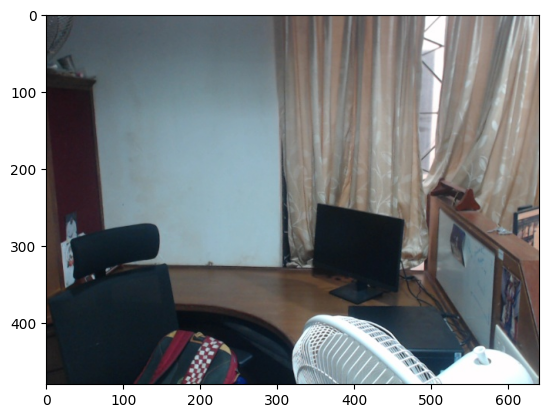

In [76]:
img1 = cv2.imread("images/Camera 6.jpg")
img1 = cv2.cvtColor(img1 , cv2.COLOR_BGR2RGB)
plt.imshow(img1)

creating a big mask to accomodate all the three images and shifting the reference image by a factor of (x , y)

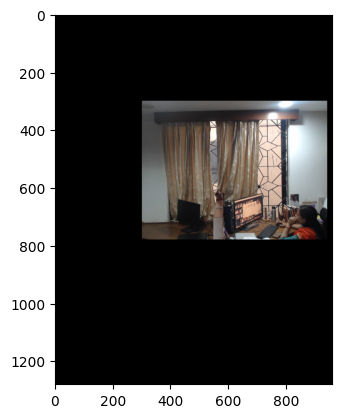

In [77]:
img2 = cv2.imread("images/Camera 2.jpg")
img2 = cv2.cvtColor(img2 , cv2.COLOR_BGR2RGB)
shift = np.array([[1 , 0 , 300],
                 [0 , 1 , 300],
                 [0 , 0 , 1] ] , dtype=np.float32)
img2 = cv2.warpPerspective(img2 , shift , (img2.shape[0]*2 , img2.shape[1]*2))
plt.imshow(img2)

In [79]:
sift = cv2.SIFT_create()

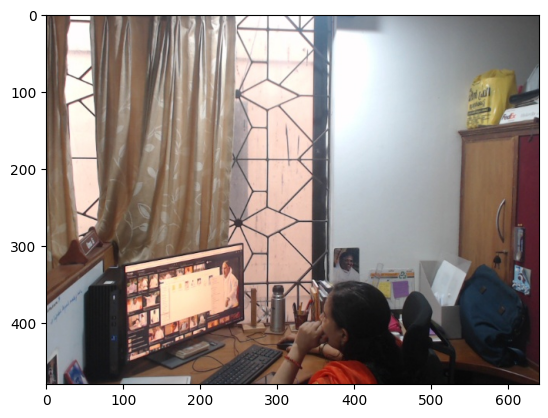

In [78]:
img3 = cv2.imread("images/Camera 4.jpg")
img3 = cv2.cvtColor(img3 , cv2.COLOR_BGR2RGB)
kp2 , des2 = sift.detectAndCompute(img2 , None)
plt.imshow(img3)

computing keypoints and descriptors of the images

In [80]:
sift = cv2.SIFT_create()
bf = cv2.BFMatcher(cv2.NORM_L1 , crossCheck = False)

In [81]:
kp1 , des1 = sift.detectAndCompute(img1 , None)
kp2 , des2 = sift.detectAndCompute(img2 , None)
kp3 , des3 = sift.detectAndCompute(img3 , None)

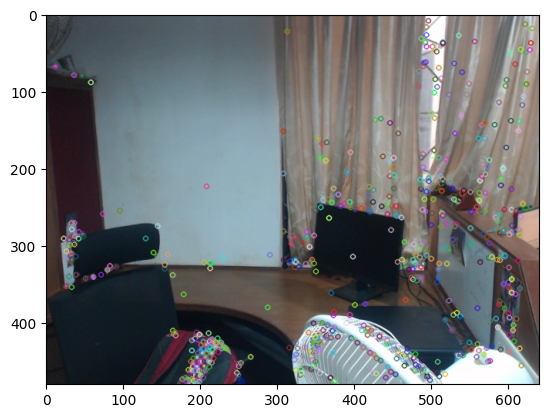

In [72]:
img1kp = cv2.drawKeypoints(img1 , kp1 , None)
plt.imshow(img1kp)

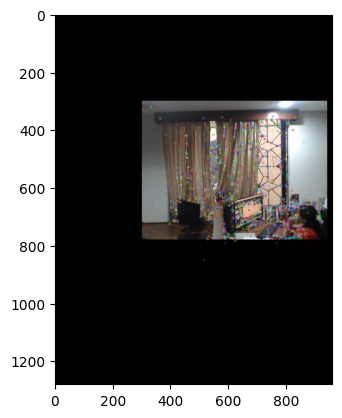

In [82]:
img2kp = cv2.drawKeypoints(img2 , kp2 , None)
plt.imshow(img2kp)

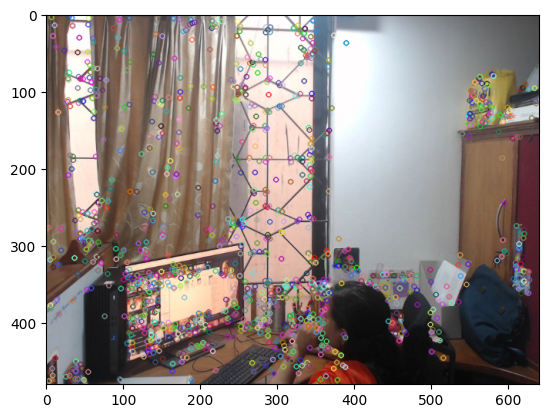

In [83]:
img3kp = cv2.drawKeypoints(img3 , kp3 , None)
plt.imshow(img3kp)

Matching the images such that making middle image as reference

newspaper1 matching to newpaper2

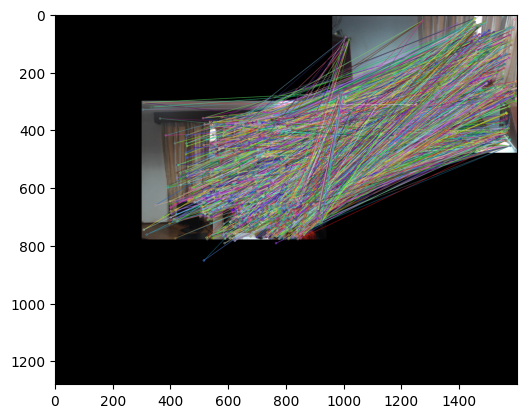

In [84]:
rawMatching1 = bf.knnMatch(des2 , des1 , k=2)
plt.imshow(cv2.drawMatchesKnn(img2 , kp2 , img1 , kp1 , rawMatching1 , None))

newspaper 3 matching to newspaper 2

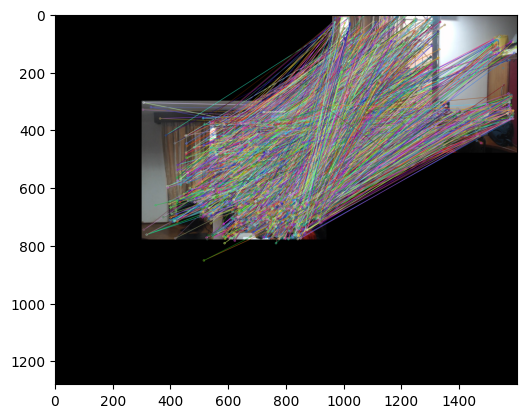

In [85]:
rawMatching2 = bf.knnMatch(des2 , des3 , k=2)
plt.imshow(cv2.drawMatchesKnn(img2 , kp2 , img3 , kp3 , rawMatching2 , None))

Removing keypoints matched to noise , resulting into genrating good keypoints

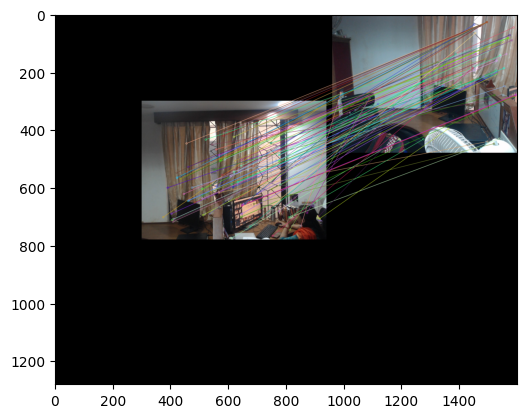

In [86]:
def GenrateGoodKeyPoints(rawMatches):
    goodKeypoints = []
    goodMatches = []
    for m1 , m2 in rawMatches:
        if m1.distance < 0.8 * m2.distance:
            goodMatches.append([m1])
            goodKeypoints.append((m1.trainIdx , m1.queryIdx))
    return goodMatches , goodKeypoints
        
matches1 , keypoints1 = GenrateGoodKeyPoints(rawMatching1)
matches2 , keypoints2 = GenrateGoodKeyPoints(rawMatching2)
plt.imshow(cv2.drawMatchesKnn(img2 , kp2 , img1 , kp1 , matches1 , None , flags=2))

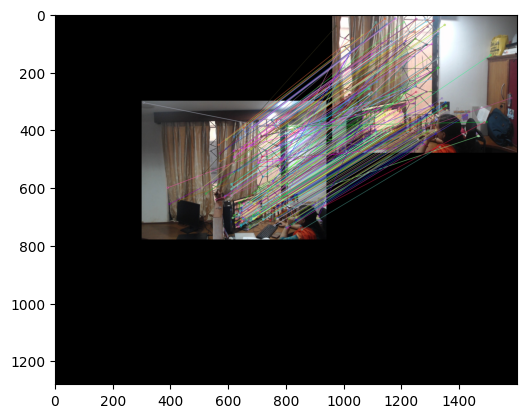

In [87]:
plt.imshow(cv2.drawMatchesKnn(img2 , kp2 , img3 , kp3 , matches2 , None , flags=2))

computing homography of the two images with respect to its reference image

In [88]:
img21kp = np.array([kp2[i].pt for (_, i) in keypoints1])
img12kp = np.array([kp1[i].pt for (i , _) in keypoints1])
H21 , _ = cv2.findHomography(np.float32(img12kp) , np.float32(img21kp) , cv2.RANSAC , 5.0)
H21

array([[ 1.11470810e+00,  5.57536208e-02,  6.18072108e+01],
       [ 1.40093933e-01,  9.25827983e-01,  4.20818827e+02],
       [ 2.96405478e-04, -7.02946165e-05,  1.00000000e+00]])

In [89]:
img32kp = np.array([kp2[i].pt for (_, i) in keypoints2])
img23kp = np.array([kp3[i].pt for (i , _) in keypoints2])
H32 , _ = cv2.findHomography(np.float32(img23kp) , np.float32(img32kp) , cv2.RANSAC , 5.0)
H32

array([[ 1.82119819e-01, -1.73202837e-02,  5.58176223e+02],
       [-3.91528621e-01,  6.47330827e-01,  4.26556152e+02],
       [-5.83281937e-04, -5.33568739e-05,  1.00000000e+00]])

tranforming images with respect to its reference or destination keypoints

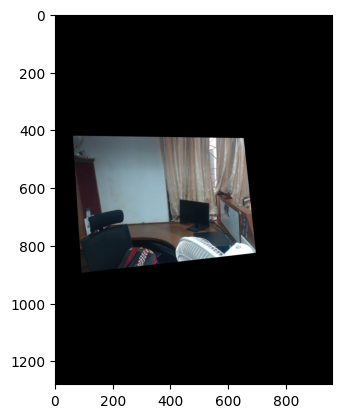

In [90]:
img1Transformed = cv2.warpPerspective(img1 , H21, (img2.shape[1] , img2.shape[0]))
plt.imshow(img1Transformed)

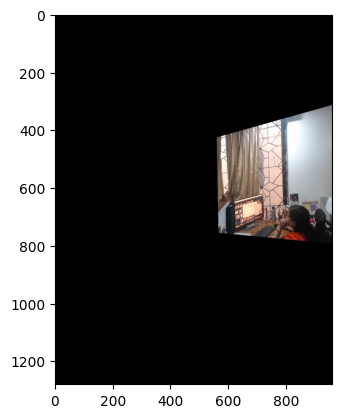

In [91]:
img3Transformed = cv2.warpPerspective(img3 , H32, (img2.shape[1] , img2.shape[0]))
plt.imshow(img3Transformed)

performing image subtraction to remove overlapping regions and adding them up

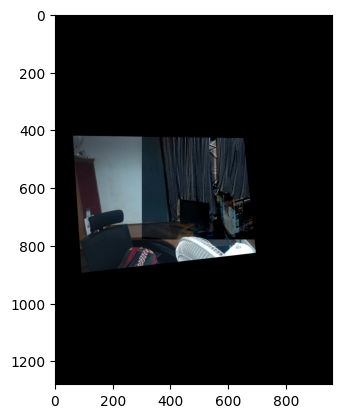

In [92]:
subtract12 = cv2.subtract(img1Transformed , img2)
plt.imshow(subtract12)

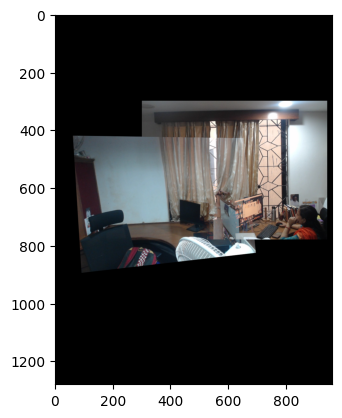

In [93]:
P12 = cv2.add(subtract12 , img2)
plt.imshow(P12)

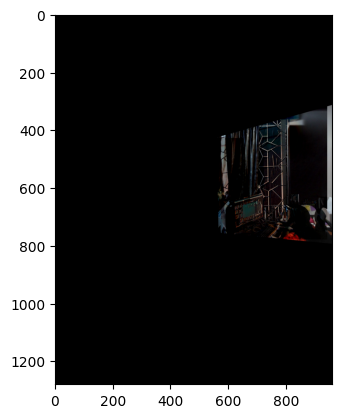

In [94]:
subtract123 = cv2.subtract(img3Transformed , P12)
plt.imshow(subtract123)

result

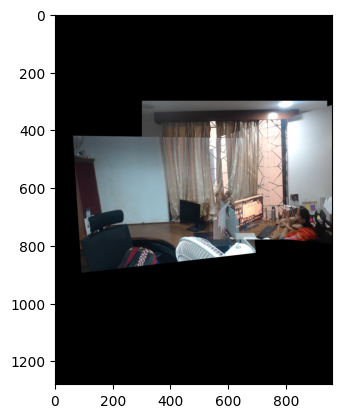

In [95]:
PFinal = cv2.add(P12 , subtract123)
plt.imshow(PFinal)

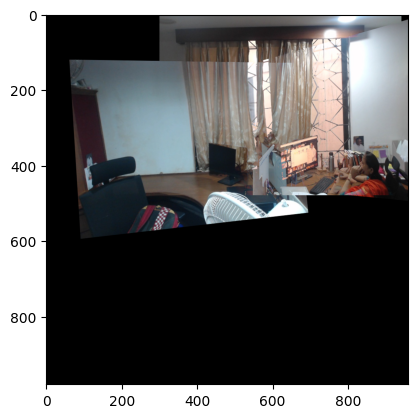

In [96]:
PFinal = PFinal[300:1400,:1550]
plt.imshow(PFinal)

In [28]:
cv2.imwrite("simulhomographyres.png" , cv2.cvtColor(PFinal , cv2.COLOR_BGR2RGB))

True